In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt
from tqdm import tqdm
M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
seq_exp = np.load("seq_exp.npy")
seq_op = np.load("gen_23.npy")
seq_partial = seq_exp[:-80]
zt_freqs = cp.linspace(-90e3, 30e3, 1000)
zt_rabi = 1.01e3
zt_pulse = 500e-6
print(zt_rabi * zt_pulse)

0.505


In [4]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(1000, temp)
cr.raman_cool_with_pumping(
    molecules_dev=mol_0,
    pulses_dev=seq_partial,
    res=res,
)

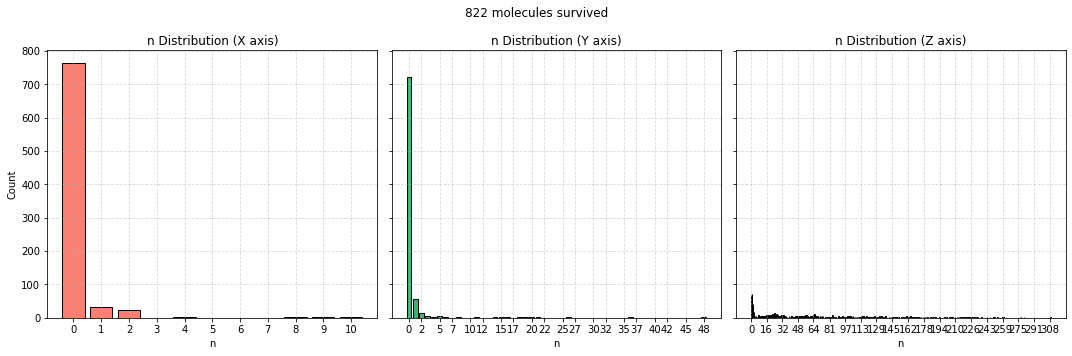

In [5]:
dist = cr.get_n_distribution_gpu(mol_0, max_bins=20)

In [6]:
frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:16<00:00, 60.67it/s]


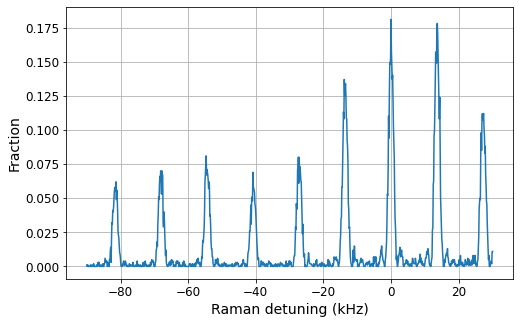

In [7]:
plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations)/1000)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

### Optimized

In [32]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(1000, temp)
cr.raman_cool_with_pumping(
    molecules_dev=mol_0,
    pulses_dev=seq_op,
    res=res,
)

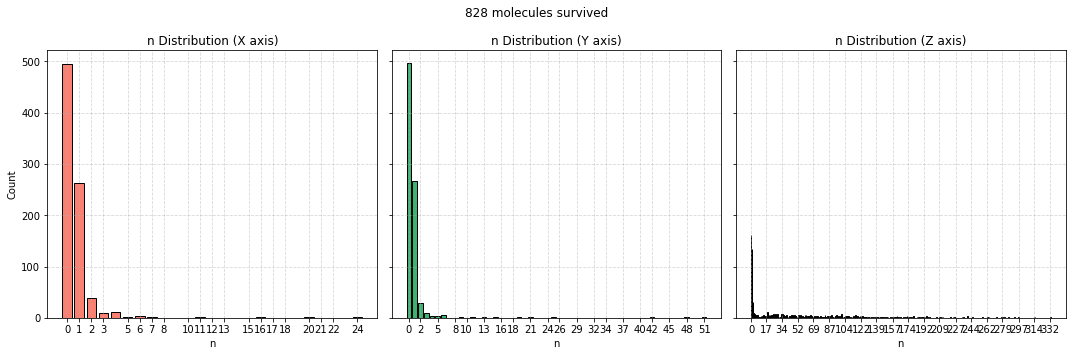

In [33]:
dist = cr.get_n_distribution_gpu(mol_0, max_bins=20)

In [36]:
frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:16<00:00, 59.74it/s]


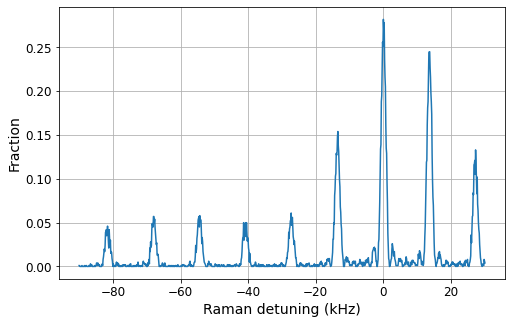

In [37]:
plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations)/1000)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

### Compare

11it [09:07, 49.78s/it]


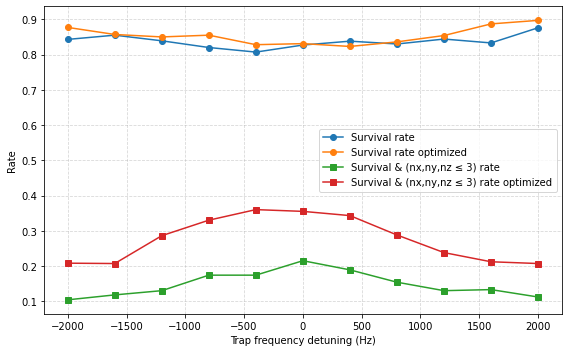

In [10]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

temp = [25e-6, 25e-6, 25e-6]
trap_dets = np.linspace(-2e3, 2e3, 11)

N_mol = 1000
survival_rate = np.empty(len(trap_dets), dtype=float)
le3_rate = np.empty(len(trap_dets), dtype=float)
survival_rate_op = np.empty(len(trap_dets), dtype=float)
le3_rate_op = np.empty(len(trap_dets), dtype=float)

for i, det in tqdm(enumerate(trap_dets)):
    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_partial,
        res=res,
        trap_detuning=(0, 0, float(det)),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate[i] = float((cp.count_nonzero(le3) / N_mol).get())

    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_op,
        res=res,
        trap_detuning=(0, 0, float(det)),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate_op[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate_op[i] = float((cp.count_nonzero(le3) / N_mol).get())

plt.figure(figsize=(8, 5))
plt.plot(trap_dets, survival_rate, marker="o", label="Survival rate")
plt.plot(trap_dets, survival_rate_op, marker="o", label="Survival rate optimized")
plt.plot(trap_dets, le3_rate, marker="s", label="Survival & (nx,ny,nz ≤ 3) rate")
plt.plot(trap_dets, le3_rate_op, marker="s", label="Survival & (nx,ny,nz ≤ 3) rate optimized")
plt.xlabel("Trap frequency detuning (Hz)")
plt.ylabel("Rate")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


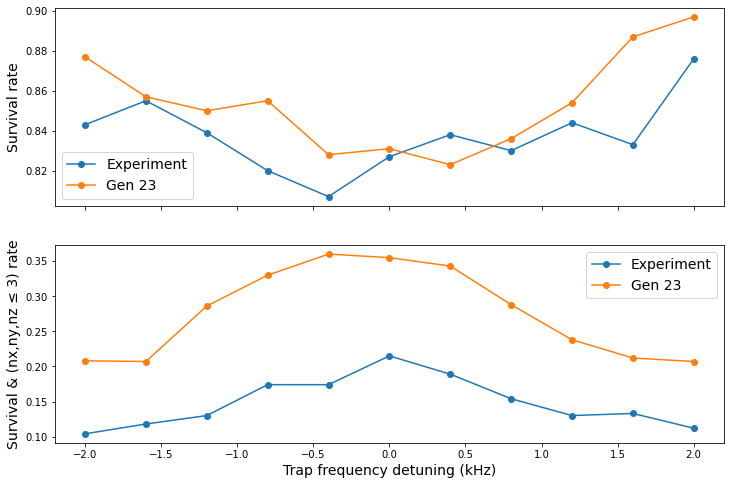

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(trap_dets*1e-3, survival_rate, marker="o", label="Experiment")
ax[0].plot(trap_dets*1e-3, survival_rate_op, marker="o", label="Gen 23")
ax[1].plot(trap_dets*1e-3, le3_rate, marker="o", label="Experiment")
ax[1].plot(trap_dets*1e-3, le3_rate_op, marker="o", label="Gen 23")
ax[1].set_xlabel("Trap frequency detuning (kHz)", fontsize=14)
ax[0].set_ylabel("Survival rate", fontsize=14)
ax[1].set_ylabel("Survival & (nx,ny,nz ≤ 3) rate", fontsize=14)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

In [8]:
trap_dets = np.linspace(-2e3, 2e3, 9)
zt_freqs = cp.linspace(-40e3, 40e3, 1000)
N_mol = 1000
temp = [25e-6, 25e-6, 25e-6]
polarizations_exp = np.empty((trap_dets.shape[0], zt_freqs.shape[0]))
polarizations_op = np.empty((trap_dets.shape[0], zt_freqs.shape[0]))

for i, det in tqdm(enumerate(trap_dets), total=len(trap_dets)):
    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)
    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_partial,
        res=res,
        trap_detuning=(0, 0, float(det)),
        show_progress=False,
    )

    frequencys, polarizations = cr.raman_sideband_thermometry(
        molecules_dev=mol_0,
        axis=2,
        frequencys=zt_freqs,
        rabi_freq=zt_rabi,
        pulse_time=zt_pulse,
        res=res,
        k_max=2,
        trap_detuning=(0, 0, float(det)),
        show_progress=False
    )
    polarizations_exp[i] = polarizations.get()

    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)
    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_op,
        res=res,
        trap_detuning=(0, 0, float(det)),
        show_progress=False,
    )

    frequencys, polarizations = cr.raman_sideband_thermometry(
        molecules_dev=mol_0,
        axis=2,
        frequencys=zt_freqs,
        rabi_freq=zt_rabi,
        pulse_time=zt_pulse,
        res=res,
        k_max=2,
        trap_detuning=(0, 0, float(det)),
        show_progress=False
    )
    polarizations_op[i] = polarizations.get()
    

100%|██████████| 9/9 [12:05<00:00, 80.59s/it]


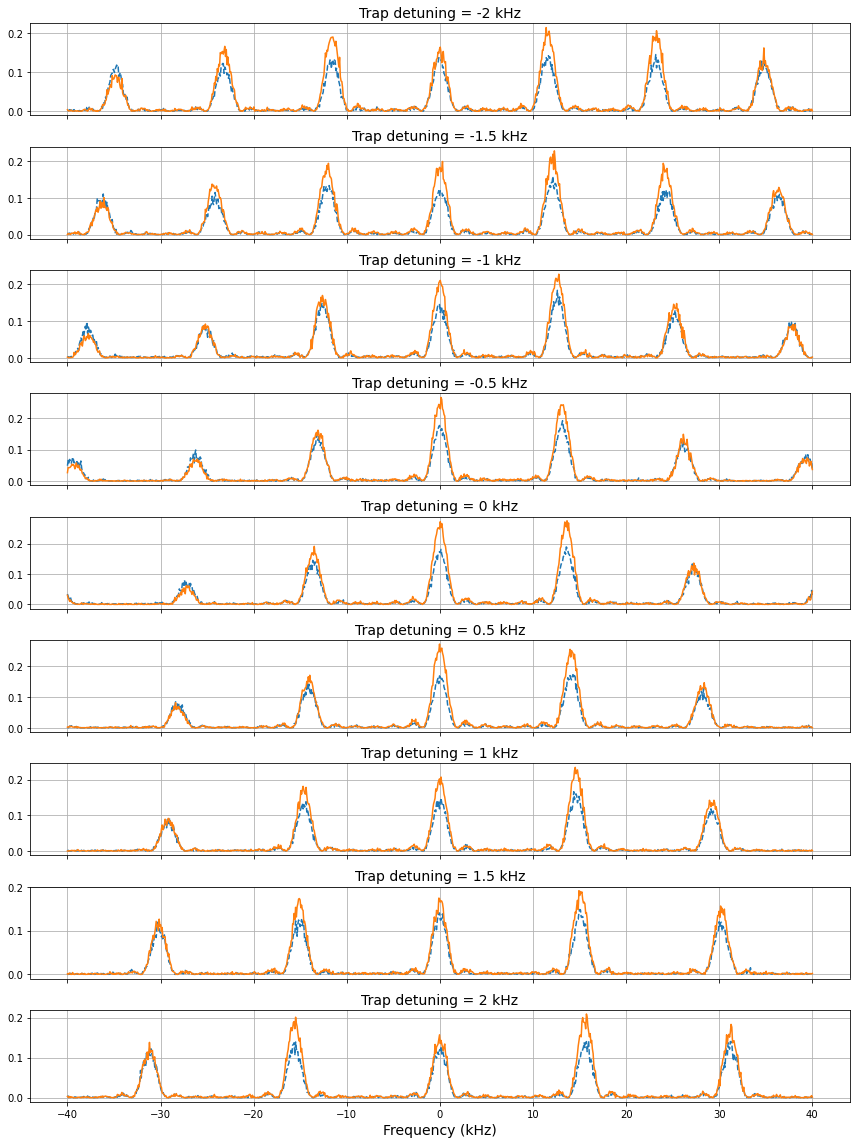

In [9]:
fig, ax = plt.subplots(len(trap_dets), 1, figsize=(12, 16), sharex=True)
for i, det in enumerate(trap_dets):
    ax[i].plot(frequencys.get()/1e3, polarizations_exp[i]/1000, '--')
    ax[i].plot(frequencys.get()/1e3, polarizations_op[i]/1000)
    ax[i].set_title(f"Trap detuning = {det/1e3:.2g} kHz", fontsize=14)
    ax[i].grid()
ax[-1].set_xlabel("Frequency (kHz)", fontsize=14)
fig.tight_layout()

### Vary overall Rabi

11it [09:23, 51.22s/it]


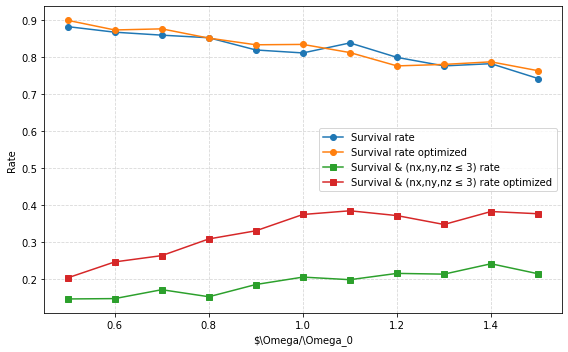

In [42]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

temp = [25e-6, 25e-6, 25e-6]
rabi_scales = np.linspace(0.5, 1.5, 11)

N_mol = 1000
survival_rate = np.empty(len(rabi_scales), dtype=float)
le3_rate = np.empty(len(rabi_scales), dtype=float)
survival_rate_op = np.empty(len(rabi_scales), dtype=float)
le3_rate_op = np.empty(len(rabi_scales), dtype=float)

for i, r in tqdm(enumerate(rabi_scales)):
    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_partial,
        res=res,
        Rabi_scale=r,
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate[i] = float((cp.count_nonzero(le3) / N_mol).get())

    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_op,
        res=res,
        Rabi_scale=r,
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate_op[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate_op[i] = float((cp.count_nonzero(le3) / N_mol).get())

plt.figure(figsize=(8, 5))
plt.plot(rabi_scales, survival_rate, marker="o", label="Survival rate")
plt.plot(rabi_scales, survival_rate_op, marker="o", label="Survival rate optimized")
plt.plot(rabi_scales, le3_rate, marker="s", label="Survival & (nx,ny,nz ≤ 3) rate")
plt.plot(rabi_scales, le3_rate_op, marker="s", label="Survival & (nx,ny,nz ≤ 3) rate optimized")
plt.xlabel("$\Omega/\Omega_0")
plt.ylabel("Rate")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


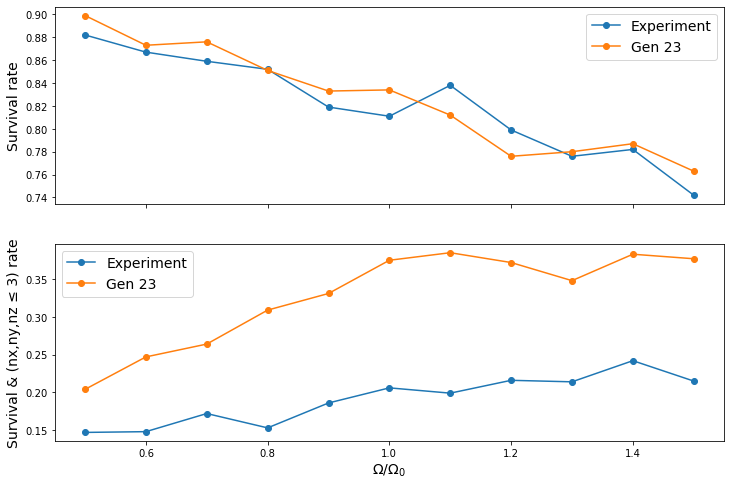

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(rabi_scales, survival_rate, marker="o", label="Experiment")
ax[0].plot(rabi_scales, survival_rate_op, marker="o", label="Gen 23")
ax[1].plot(rabi_scales, le3_rate, marker="o", label="Experiment")
ax[1].plot(rabi_scales, le3_rate_op, marker="o", label="Gen 23")
ax[1].set_xlabel("$\Omega/\Omega_0$", fontsize=14)
ax[0].set_ylabel("Survival rate", fontsize=14)
ax[1].set_ylabel("Survival & (nx,ny,nz ≤ 3) rate", fontsize=14)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

In [5]:
trap_dets = np.linspace(-2e3, 2e3, 9)
zt_freqs = cp.linspace(-40e3, 40e3, 1000)
rabi_scales = np.linspace(0.5, 1.5, 11)

polarizations_exp = np.empty((rabi_scales.shape[0], frequencys.shape[0]))
polarizations_op = np.empty((rabi_scales.shape[0], frequencys.shape[0]))

for i, r in tqdm(enumerate(rabi_scales), total=len(rabi_scales)):
    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)
    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_partial,
        res=res,
        Rabi_scale=r,
        show_progress=False,
    )

    frequencys, polarizations = cr.raman_sideband_thermometry(
        molecules_dev=mol_0,
        axis=2,
        frequencys=zt_freqs,
        rabi_freq=zt_rabi,
        pulse_time=zt_pulse,
        res=res,
        k_max=2,
        show_progress=False
    )
    polarizations_exp[i] = polarizations.get()

    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)
    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_op,
        res=res,
        Rabi_scale=r,
        show_progress=False,
    )

    frequencys, polarizations = cr.raman_sideband_thermometry(
        molecules_dev=mol_0,
        axis=2,
        frequencys=zt_freqs,
        rabi_freq=zt_rabi,
        pulse_time=zt_pulse,
        res=res,
        k_max=2,
        show_progress=False
    )
    polarizations_op[i] = polarizations.get()
    

NameError: name 'frequencys' is not defined

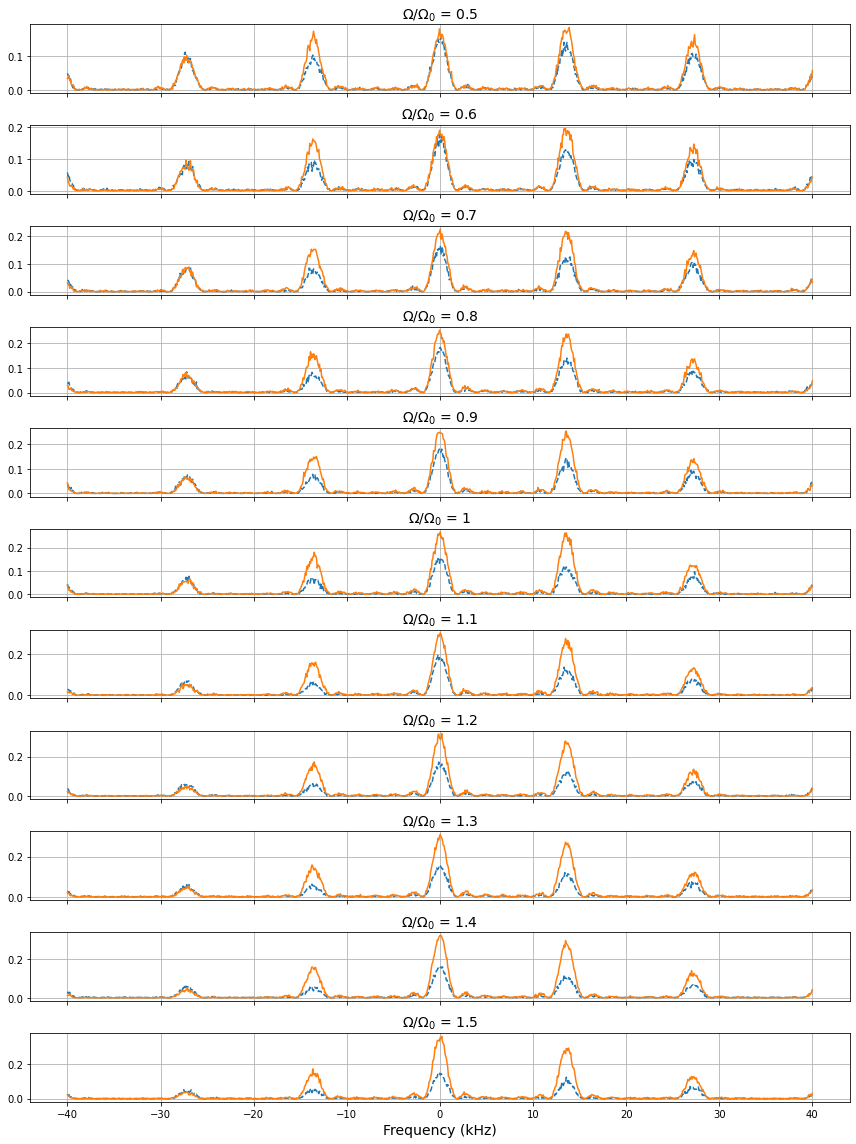

In [48]:
fig, ax = plt.subplots(len(rabi_scales), 1, figsize=(12, 16), sharex=True)
for i, r in enumerate(rabi_scales):
    ax[i].plot(frequencys.get()/1e3, polarizations_exp[i]/1000, '--')
    ax[i].plot(frequencys.get()/1e3, polarizations_op[i]/1000)
    ax[i].set_title(f"$\Omega/\Omega_0$ = {r:.2g}", fontsize=14)
    ax[i].grid()
ax[-1].set_xlabel("Frequency (kHz)", fontsize=14)
fig.tight_layout()

### $\Omega/\Omega_0$ at z axis

In [7]:
temp = [25e-6, 25e-6, 25e-6]
rabi_scales = np.linspace(0.5, 1.5, 11)

N_mol = 1000
survival_rate = np.empty(len(rabi_scales), dtype=float)
le3_rate = np.empty(len(rabi_scales), dtype=float)
survival_rate_op = np.empty(len(rabi_scales), dtype=float)
le3_rate_op = np.empty(len(rabi_scales), dtype=float)

for i, r in tqdm(enumerate(rabi_scales), total=len(rabi_scales)):
    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_partial,
        res=res,
        Rabi_scale=cp.array([1, 1, r]),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate[i] = float((cp.count_nonzero(le3) / N_mol).get())

    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_op,
        res=res,
        Rabi_scale=cp.array([1, 1, r]),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate_op[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate_op[i] = float((cp.count_nonzero(le3) / N_mol).get())


100%|██████████| 11/11 [09:25<00:00, 51.39s/it]


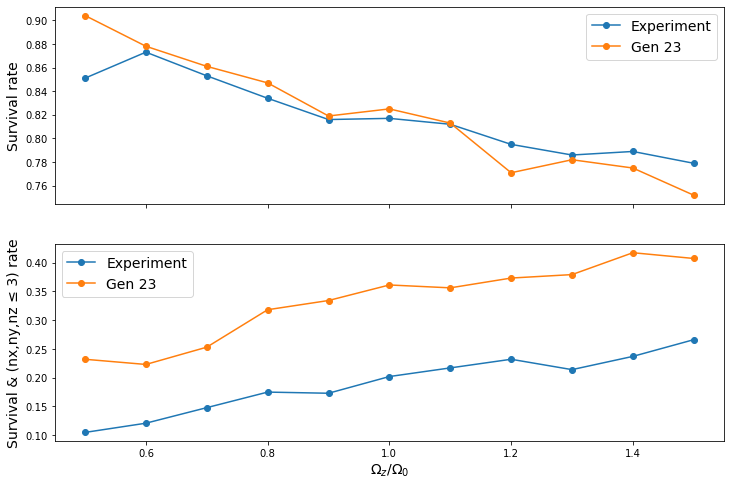

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(rabi_scales, survival_rate, marker="o", label="Experiment")
ax[0].plot(rabi_scales, survival_rate_op, marker="o", label="Gen 23")
ax[1].plot(rabi_scales, le3_rate, marker="o", label="Experiment")
ax[1].plot(rabi_scales, le3_rate_op, marker="o", label="Gen 23")
ax[1].set_xlabel("$\Omega_z/\Omega_0$", fontsize=14)
ax[0].set_ylabel("Survival rate", fontsize=14)
ax[1].set_ylabel("Survival & (nx,ny,nz ≤ 3) rate", fontsize=14)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

### $\Omega_x/\Omega_0$

In [12]:
temp = [25e-6, 25e-6, 25e-6]
rabi_scales = np.linspace(0.1, 1.5, 15)

N_mol = 1000
survival_rate = np.empty(len(rabi_scales), dtype=float)
le3_rate = np.empty(len(rabi_scales), dtype=float)
survival_rate_op = np.empty(len(rabi_scales), dtype=float)
le3_rate_op = np.empty(len(rabi_scales), dtype=float)

for i, r in tqdm(enumerate(rabi_scales), total=len(rabi_scales)):
    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_partial,
        res=res,
        Rabi_scale=cp.array([r, 1, 1]),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate[i] = float((cp.count_nonzero(le3) / N_mol).get())

    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_op,
        res=res,
        Rabi_scale=cp.array([r, 1, 1]),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate_op[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate_op[i] = float((cp.count_nonzero(le3) / N_mol).get())


100%|██████████| 15/15 [13:15<00:00, 53.04s/it]


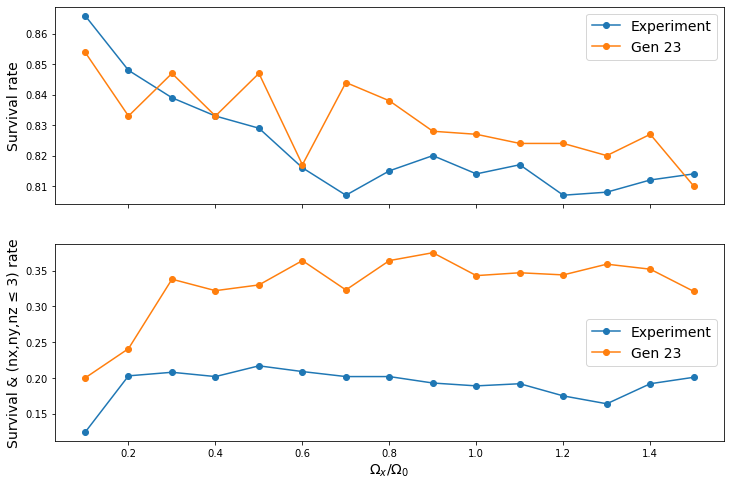

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(rabi_scales, survival_rate, marker="o", label="Experiment")
ax[0].plot(rabi_scales, survival_rate_op, marker="o", label="Gen 23")
ax[1].plot(rabi_scales, le3_rate, marker="o", label="Experiment")
ax[1].plot(rabi_scales, le3_rate_op, marker="o", label="Gen 23")
ax[1].set_xlabel("$\Omega_x/\Omega_0$", fontsize=14)
ax[0].set_ylabel("Survival rate", fontsize=14)
ax[1].set_ylabel("Survival & (nx,ny,nz ≤ 3) rate", fontsize=14)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

### $\Omega_y/\Omega_0$

In [14]:
temp = [25e-6, 25e-6, 25e-6]
rabi_scales = np.linspace(0.1, 1.5, 15)

N_mol = 1000
survival_rate = np.empty(len(rabi_scales), dtype=float)
le3_rate = np.empty(len(rabi_scales), dtype=float)
survival_rate_op = np.empty(len(rabi_scales), dtype=float)
le3_rate_op = np.empty(len(rabi_scales), dtype=float)

for i, r in tqdm(enumerate(rabi_scales), total=len(rabi_scales)):
    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_partial,
        res=res,
        Rabi_scale=cp.array([1, r, 1]),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate[i] = float((cp.count_nonzero(le3) / N_mol).get())

    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_op,
        res=res,
        Rabi_scale=cp.array([1, r, 1]),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate_op[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate_op[i] = float((cp.count_nonzero(le3) / N_mol).get())


100%|██████████| 15/15 [13:10<00:00, 52.67s/it]


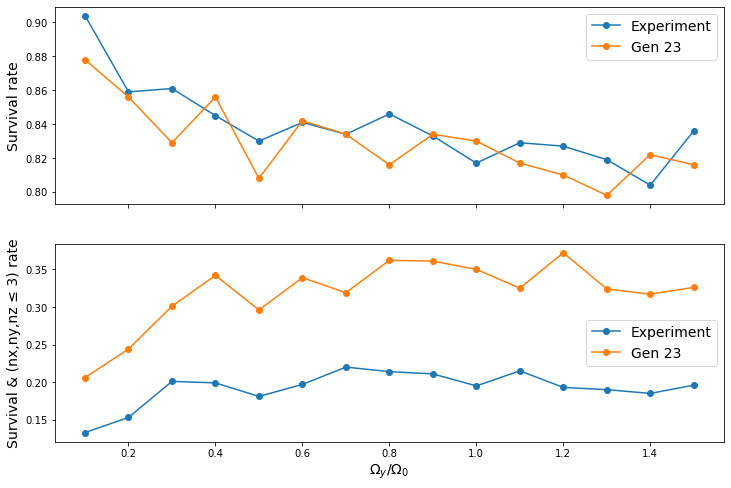

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(rabi_scales, survival_rate, marker="o", label="Experiment")
ax[0].plot(rabi_scales, survival_rate_op, marker="o", label="Gen 23")
ax[1].plot(rabi_scales, le3_rate, marker="o", label="Experiment")
ax[1].plot(rabi_scales, le3_rate_op, marker="o", label="Gen 23")
ax[1].set_xlabel("$\Omega_y/\Omega_0$", fontsize=14)
ax[0].set_ylabel("Survival rate", fontsize=14)
ax[1].set_ylabel("Survival & (nx,ny,nz ≤ 3) rate", fontsize=14)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

### Sanity check, scan close to zero

In [16]:
temp = [25e-6, 25e-6, 25e-6]
rabi_scales = np.linspace(0.01, 0.2, 20)

N_mol = 1000
survival_rate = np.empty(len(rabi_scales), dtype=float)
le3_rate = np.empty(len(rabi_scales), dtype=float)
survival_rate_op = np.empty(len(rabi_scales), dtype=float)
le3_rate_op = np.empty(len(rabi_scales), dtype=float)

for i, r in tqdm(enumerate(rabi_scales), total=len(rabi_scales)):
    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_partial,
        res=res,
        Rabi_scale=cp.array([1, r, 1]),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate[i] = float((cp.count_nonzero(le3) / N_mol).get())

    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_op,
        res=res,
        Rabi_scale=cp.array([1, r, 1]),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate_op[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate_op[i] = float((cp.count_nonzero(le3) / N_mol).get())


100%|██████████| 20/20 [15:56<00:00, 47.85s/it]


In [23]:
mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)
baseline = float((cp.count_nonzero(survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3)) / N_mol).get())
print(baseline)

0.152


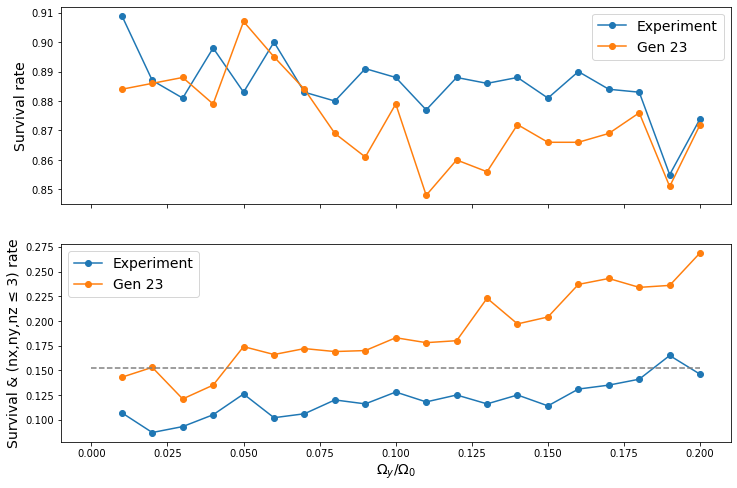

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(rabi_scales, survival_rate, marker="o", label="Experiment")
ax[0].plot(rabi_scales, survival_rate_op, marker="o", label="Gen 23")
ax[1].plot(rabi_scales, le3_rate, marker="o", label="Experiment")
ax[1].plot(rabi_scales, le3_rate_op, marker="o", label="Gen 23")
ax[1].hlines(baseline, 0, 0.2, color='gray', linestyle='--')
ax[1].set_xlabel("$\Omega_y/\Omega_0$", fontsize=14)
ax[0].set_ylabel("Survival rate", fontsize=14)
ax[1].set_ylabel("Survival & (nx,ny,nz ≤ 3) rate", fontsize=14)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

### Divert power

In [10]:
trap_dets = np.linspace(-2e3, 2e3, 9)
zt_freqs = cp.linspace(-40e3, 40e3, 1000)

mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)
cr.raman_cool_with_pumping(
    molecules_dev=mol_0,
    pulses_dev=seq_partial,
    res=res,
    Rabi_scale=1,
    show_progress=True,
)

frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2,
    show_progress=True
)
polarizations_exp = polarizations.get()

mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)
cr.raman_cool_with_pumping(
    molecules_dev=mol_0,
    pulses_dev=seq_partial,
    res=res,
    Rabi_scale=[0.5, 0.5, 2],
    show_progress=True,
)

frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2,
    show_progress=True
)

polarizations_power = polarizations.get()


Raman thermometry: 100%|██████████| 1000/1000 [00:16<00:00, 60.93it/s]


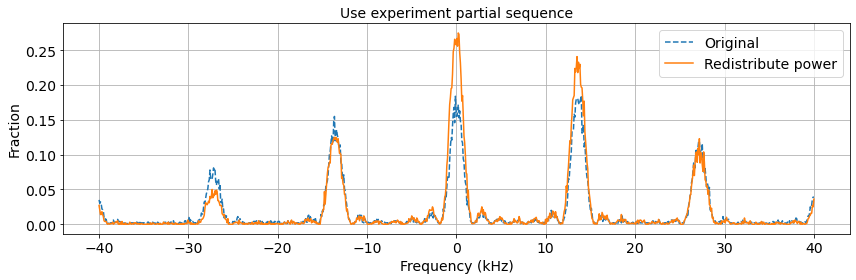

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharex=True)
ax.plot(frequencys.get()/1e3, polarizations_exp/1000, '--', label='Original')
ax.plot(frequencys.get()/1e3, polarizations_power/1000, label='Redistribute power')
ax.grid()
ax.set_xlabel("Frequency (kHz)", fontsize=14)
ax.set_ylabel("Fraction", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title("Use experiment partial sequence", fontsize=14)
ax.legend(fontsize=14)
fig.tight_layout()

### Scan $\Omega_z$ further out

In [11]:
seq_op = np.load("gen_23.npy")

In [9]:
temp = [25e-6, 25e-6, 25e-6]
rabi_scales = np.linspace(0.5, 5, 19)

N_mol = 1000
survival_rate = np.empty(len(rabi_scales), dtype=float)
le3_rate = np.empty(len(rabi_scales), dtype=float)

for i, r in tqdm(enumerate(rabi_scales), total=len(rabi_scales)):
    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_partial,
        res=res,
        Rabi_scale=cp.array([1, 1, r]),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate[i] = float((cp.count_nonzero(le3) / N_mol).get())

100%|██████████| 19/19 [09:18<00:00, 29.42s/it]


In [12]:
temp = [25e-6, 25e-6, 25e-6]
rabi_scales = np.linspace(0.5, 5, 19)

N_mol = 1000
survival_rate_op = np.empty(len(rabi_scales), dtype=float)
le3_rate_op = np.empty(len(rabi_scales), dtype=float)

for i, r in tqdm(enumerate(rabi_scales), total=len(rabi_scales)):
    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_op,
        res=res,
        Rabi_scale=cp.array([1, 1, r]),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate_op[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate_op[i] = float((cp.count_nonzero(le3) / N_mol).get())

100%|██████████| 19/19 [08:21<00:00, 26.40s/it]


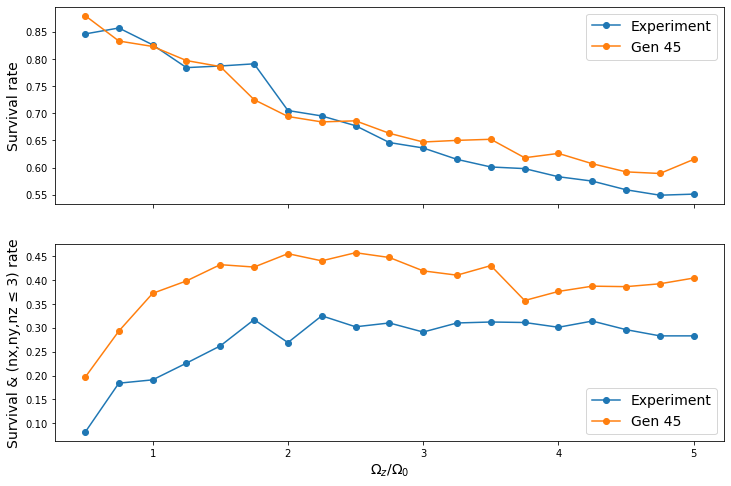

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(rabi_scales, survival_rate, marker="o", label="Experiment")
ax[0].plot(rabi_scales, survival_rate_op, marker="o", label="Gen 45")
ax[1].plot(rabi_scales, le3_rate, marker="o", label="Experiment")
ax[1].plot(rabi_scales, le3_rate_op, marker="o", label="Gen 45")
ax[1].set_xlabel("$\Omega_z/\Omega_0$", fontsize=14)
ax[0].set_ylabel("Survival rate", fontsize=14)
ax[1].set_ylabel("Survival & (nx,ny,nz ≤ 3) rate", fontsize=14)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

In [14]:
trap_dets = np.linspace(-2e3, 2e3, 9)
zt_freqs = cp.linspace(-40e3, 40e3, 1000)

mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)
cr.raman_cool_with_pumping(
    molecules_dev=mol_0,
    pulses_dev=seq_partial,
    res=res,
    Rabi_scale=1,
    show_progress=True,
)

frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2,
    show_progress=True
)
polarizations_exp = polarizations.get()

mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)
cr.raman_cool_with_pumping(
    molecules_dev=mol_0,
    pulses_dev=seq_op,
    res=res,
    Rabi_scale=[1, 1, 1.4],
    show_progress=True,
)

frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2,
    show_progress=True
)

polarizations_power = polarizations.get()


Raman thermometry: 100%|██████████| 1000/1000 [00:16<00:00, 59.20it/s]


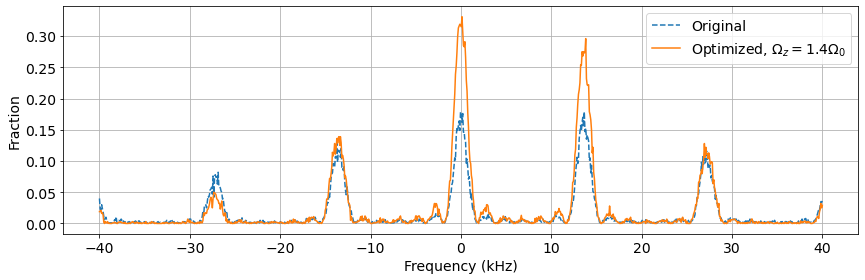

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharex=True)
ax.plot(frequencys.get()/1e3, polarizations_exp/1000, '--', label='Original')
ax.plot(frequencys.get()/1e3, polarizations_power/1000, label='Optimized, $\Omega_z=1.4\Omega_0$')
ax.grid()
ax.set_xlabel("Frequency (kHz)", fontsize=14)
ax.set_ylabel("Fraction", fontsize=14)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
fig.tight_layout()

### Only XYZ1

In [7]:
seq_XYZ1 = seq_op[40:80]

In [8]:
seq_XYZ1

array([[ 2.00000000e+00, -5.00000000e+00,  6.87600517e+03,
         5.83020896e-05],
       [ 0.00000000e+00, -2.00000000e+00,  1.55209969e+04,
         8.02771584e-05],
       [ 2.00000000e+00, -4.00000000e+00,  6.87600517e+03,
         7.69030810e-05],
       [ 1.00000000e+00, -2.00000000e+00,  9.50951061e+03,
         1.22810189e-04],
       [ 2.00000000e+00, -5.00000000e+00,  6.87600517e+03,
         5.83020896e-05],
       [ 0.00000000e+00, -1.00000000e+00,  1.36588502e+03,
         9.91693447e-06],
       [ 2.00000000e+00, -4.00000000e+00,  6.87600517e+03,
         7.69030810e-05],
       [ 1.00000000e+00, -1.00000000e+00,  4.58629994e+03,
         1.37729584e-05],
       [ 2.00000000e+00, -5.00000000e+00,  6.87600517e+03,
         5.83020896e-05],
       [ 0.00000000e+00, -2.00000000e+00,  1.55209969e+04,
         8.02771584e-05],
       [ 2.00000000e+00, -4.00000000e+00,  6.87600517e+03,
         7.69030810e-05],
       [ 1.00000000e+00, -2.00000000e+00,  9.50951061e+03,
      

Raman pulses: 100%|██████████| 40/40 [00:05<00:00,  7.88it/s]


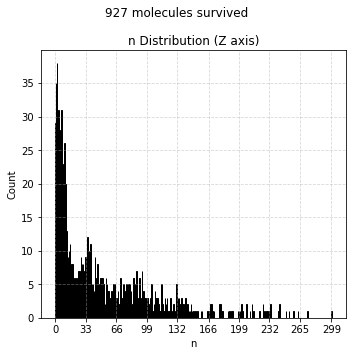

{'survival_rate_mean': array(0.927),
 'survival_rate_sem': array(0.00026778),
 'mot_mean': array([ 3.77562028,  4.78748652, 49.27292341]),
 'mot_sem': array([0.00776021, 0.00817379, 0.05630352]),
 'ground_state_rate_mean': array(0.00700701),
 'ground_state_rate_sem': array(8.4789601e-05),
 'N': array(1000),
 'B': array(1000)}

In [9]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules(1000, temp, detuning_sigma=0)
cr.raman_cool_with_pumping(mol_0, seq_XYZ1, res, show_progress=True)
dist = cr.get_n_distribution_gpu(mol_0, max_bins=10, plot=(False, False, True))
result = cr.bootstrap_stats_from_molecules(mol_0)
result

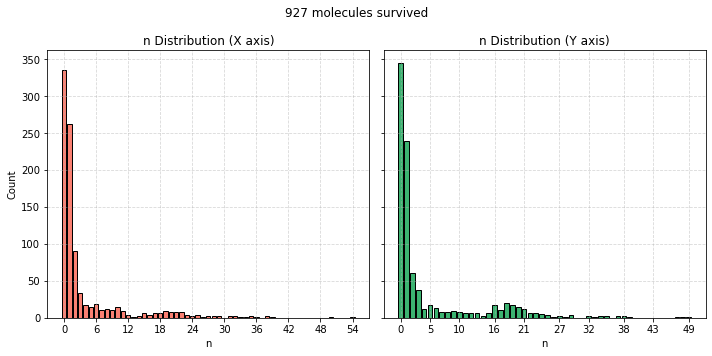

In [10]:
dist = cr.get_n_distribution_gpu(mol_0, max_bins=10, plot=(True, True, False))